# ispace 週足

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import re
import yfinance as yf

pattern = re.compile(r'(.+)\.T')

symbol = '9348.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='max', interval='1wk')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-10 00:00:00+09:00,1000.0,1501.0,950.0,1501.0,29053600,0.0,0.0
2023-04-17 00:00:00+09:00,1901.0,2373.0,1800.0,1804.0,74281100,0.0,0.0
2023-04-24 00:00:00+09:00,1964.0,2170.0,1001.0,1017.0,47943300,0.0,0.0
2023-05-01 00:00:00+09:00,1025.0,1193.0,1005.0,1010.0,16424300,0.0,0.0
2023-05-08 00:00:00+09:00,1022.0,1027.0,793.0,856.0,12355400,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-23 00:00:00+09:00,630.0,692.0,582.0,669.0,17735000,0.0,0.0
2024-12-30 00:00:00+09:00,689.0,694.0,661.0,680.0,3056200,0.0,0.0
2025-01-06 00:00:00+09:00,695.0,928.0,675.0,891.0,48515200,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

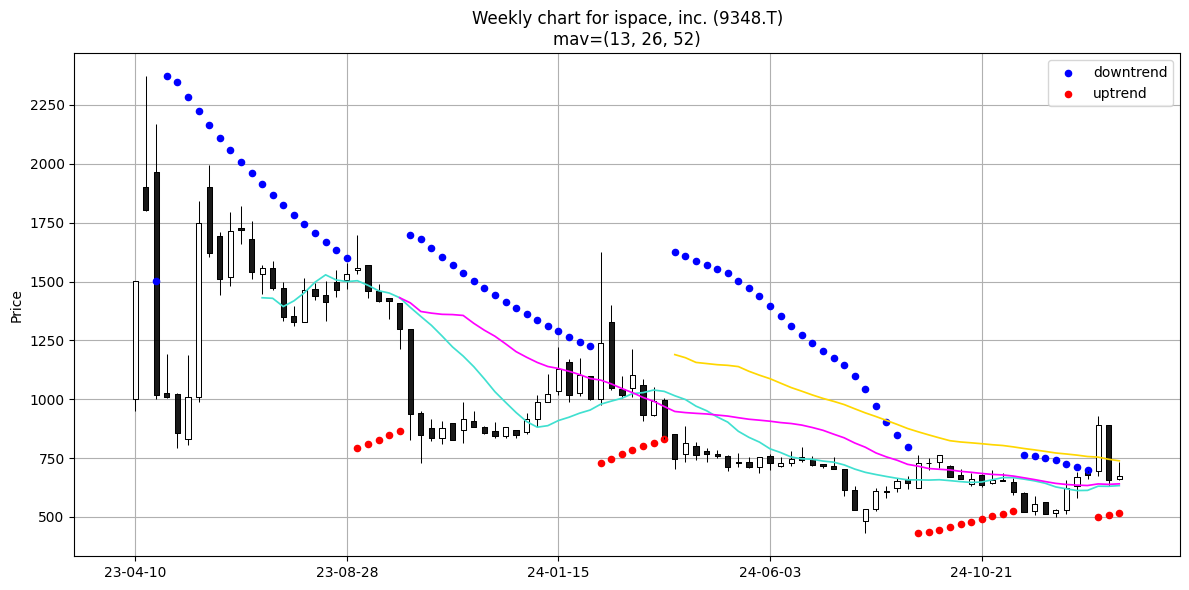

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(13, 26, 52),
    volume=False,
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Weekly chart for %s (%s)\nmav=(13, 26, 52)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Weekly chart for %s\nmav=(13, 26, 52)' % symbol)

ax.grid()
ax.legend(loc='best')

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('weekly_chart_%s.png' % m.group(1))
else:
    plt.savefig('weekly_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-01-13 00:00:00+09:00    656.0
2025-01-20 00:00:00+09:00    695.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-01-13 00:00:00+09:00     NaN
2025-01-20 00:00:00+09:00    39.0
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-01-13 00:00:00+09:00    704.0
2025-01-20 00:00:00+09:00    718.2
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-01-13 00:00:00+09:00    639.28
2025-01-20 00:00:00+09:00    645.88
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-01-13 00:00:00+09:00    852.066667
2025-01-20 00:00:00+09:00    842.480000
Name: Close, dtype: float64